# All-Convolutional Network

### Settings

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from helper_evaluation import set_all_seeds, set_deterministic
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples

RANDOM_SEED = 1
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Data Loading

In [9]:
# Set random seed
set_all_seeds(RANDOM_SEED)
set_deterministic()

transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((32,32)),
        torchvision.transforms.Grayscale(),
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize((0.5,),(0.5,))
    ])

# Load images 
dataset_dir = './data'
dataset = torchvision.datasets.ImageFolder(root = dataset_dir, transform = transform)

# Determine sizes of the training set and the test set
total_size = len(dataset)
train_size = int(np.floor(total_size * 0.6))
test_size = int(np.floor(total_size * 0.3))
valid_size = total_size - test_size - train_size

In [10]:
# Split the entire dataset into 60% of training set, 30% of test set, and 10% validation set.
training_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, valid_size])

In [11]:
# Loaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False)

### Model

In [12]:
class AllConvolutional(torch.nn.Module):
    def __init__(self, num_classes, grayscale = False):
        super().__init__()
        self.grayscale = grayscale
        self.num_classes = num_classes
        
        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3
        
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 16, kernel_size = 3, stride = 1, padding = 1, bias = False),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(inplace = True),
            
            torch.nn.Conv2d(16,16,kernel_size = 3, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(inplace = True),
            
            torch.nn.Conv2d(16,32,kernel_size = 3, stride = 1, padding = 1, bias = False),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace = True),
            
            torch.nn.Conv2d(32,32,kernel_size = 3, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace = True),
            
            torch.nn.Conv2d(32,64,kernel_size = 3, stride = 1, padding = 1, bias = False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace = True),
            
            torch.nn.Conv2d(64,64,kernel_size = 3, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace = True),
            
            torch.nn.Conv2d(64,num_classes, kernel_size = 3, stride = 1, padding = 1, bias = False),
            torch.nn.BatchNorm2d(num_classes),
            torch.nn.ReLU(inplace = True),
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten()
        )

    def forward(self, x):
        x = self.net(x)
        return x

Epoch: 001/050 | Batch 0000/0018 | Loss: 0.6720
Epoch: 001/050 | Batch 0003/0018 | Loss: 0.5458
Epoch: 001/050 | Batch 0006/0018 | Loss: 0.5378
Epoch: 001/050 | Batch 0009/0018 | Loss: 0.5520
Epoch: 001/050 | Batch 0012/0018 | Loss: 0.4896
Epoch: 001/050 | Batch 0015/0018 | Loss: 0.4749
Epoch: 001/050 | Train: 57.63% | Validation: 56.01%
Time elapsed: 0.54 min
Epoch: 002/050 | Batch 0000/0018 | Loss: 0.4090
Epoch: 002/050 | Batch 0003/0018 | Loss: 0.4057
Epoch: 002/050 | Batch 0006/0018 | Loss: 0.4149
Epoch: 002/050 | Batch 0009/0018 | Loss: 0.4090
Epoch: 002/050 | Batch 0012/0018 | Loss: 0.4455
Epoch: 002/050 | Batch 0015/0018 | Loss: 0.3483
Epoch: 002/050 | Train: 81.15% | Validation: 81.37%
Time elapsed: 1.07 min
Epoch: 003/050 | Batch 0000/0018 | Loss: 0.3293
Epoch: 003/050 | Batch 0003/0018 | Loss: 0.2908
Epoch: 003/050 | Batch 0006/0018 | Loss: 0.3408
Epoch: 003/050 | Batch 0009/0018 | Loss: 0.3212
Epoch: 003/050 | Batch 0012/0018 | Loss: 0.3312
Epoch: 003/050 | Batch 0015/0018 |

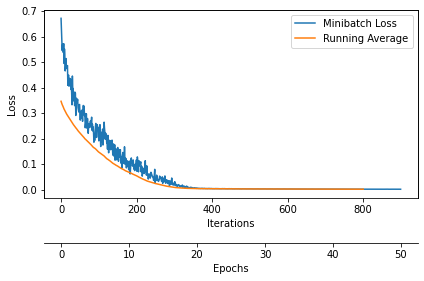

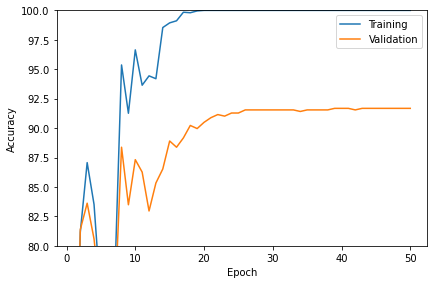

In [13]:
model = AllConvolutional(grayscale = True, num_classes = 2)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    test_loader=test_loader,
    valid_loader = valid_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=3)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

In [15]:
torch.save(model.state_dict(), 'AllConv_model.pt')

AttributeError: module 'matplotlib.pyplot' has no attribute 'compute_confusion_matrix'